In [388]:
!pip install librosa

In [389]:
!pip install keras-tuner -q

In [390]:
!pip install scikeras

In [391]:
import random
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras_tuner
import tensorflow as tf
import scipy.io as sio
import scipy.spatial as sspatial
import keras_tuner as kt
import xgboost as xgb
from numpy.matlib import repmat
from scipy.stats import pearsonr, spearmanr
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, mean_squared_error, precision_recall_curve, log_loss, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers

In [392]:
# load and inspect the dataset
df = pd.read_csv('/content/drive/MyDrive/data.csv')
# Basic dataset information
df.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


Average Tempo of each Label/Genre

In [393]:
df_filtered = df[['filename', 'tempo', 'beats', 'label']]

df_filtered = df_filtered.rename(columns={
    'filename': 'Name',
    'tempo': 'Tempo',
    'beats': 'Beats',
    'label': 'Genre',
})
df_filtered.head()

,Name,Tempo,Beats,Genre
0,blues.00081.au,103.359375,50,blues
1,blues.00022.au,95.703125,44,blues
2,blues.00031.au,151.999081,75,blues
3,blues.00012.au,184.570312,91,blues
4,blues.00056.au,161.499023,74,blues


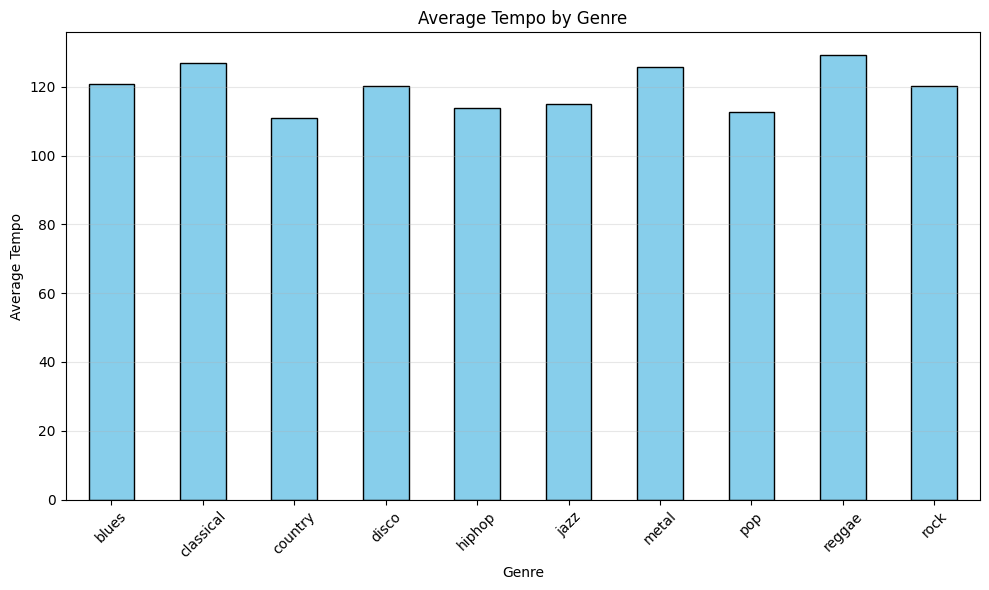

In [394]:
average_tempo = df_filtered.groupby('Genre')['Tempo'].mean()

plt.figure(figsize=(10, 6))
average_tempo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Tempo by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Tempo')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Average Beats of each Label/Genre

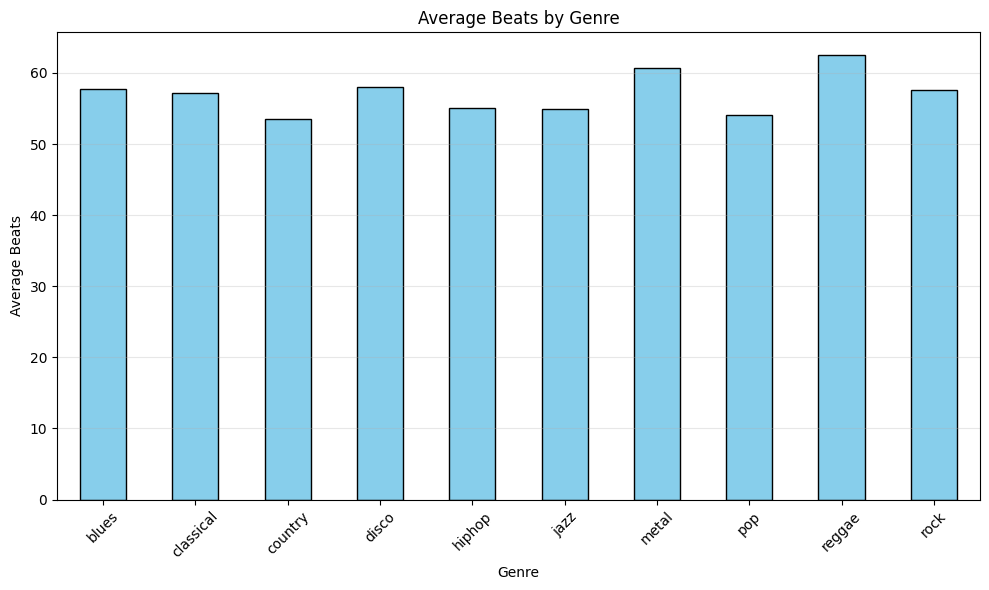

In [395]:
average_tempo = df_filtered.groupby('Genre')['Beats'].mean()


plt.figure(figsize=(10, 6))
average_tempo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Beats by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Beats')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

We would expect the average beats to correlate to the average tempo of each genre, we test that here

In [396]:
average_values = df_filtered.groupby('Genre')[['Tempo', 'Beats']].mean()

pearson_corr, pearson_p = pearsonr(average_values['Tempo'], average_values['Beats'])

spearman_corr, spearman_p = spearmanr(average_values['Tempo'], average_values['Beats'])

print(f"Pearson Correlation: {pearson_corr:.2f}, P-value: {pearson_p:.4f}")
print(f"Spearman Correlation: {spearman_corr:.2f}, P-value: {spearman_p:.4f}")

Pearson Correlation: 0.91, P-value: 0.0003
Spearman Correlation: 0.85, P-value: 0.0016


The small p value indicates a significant correlation between tempo and beats

In [397]:
# select features and labels
targets = df['label']
features = df.drop(columns = ['filename', 'label'])

Correlation Matrix

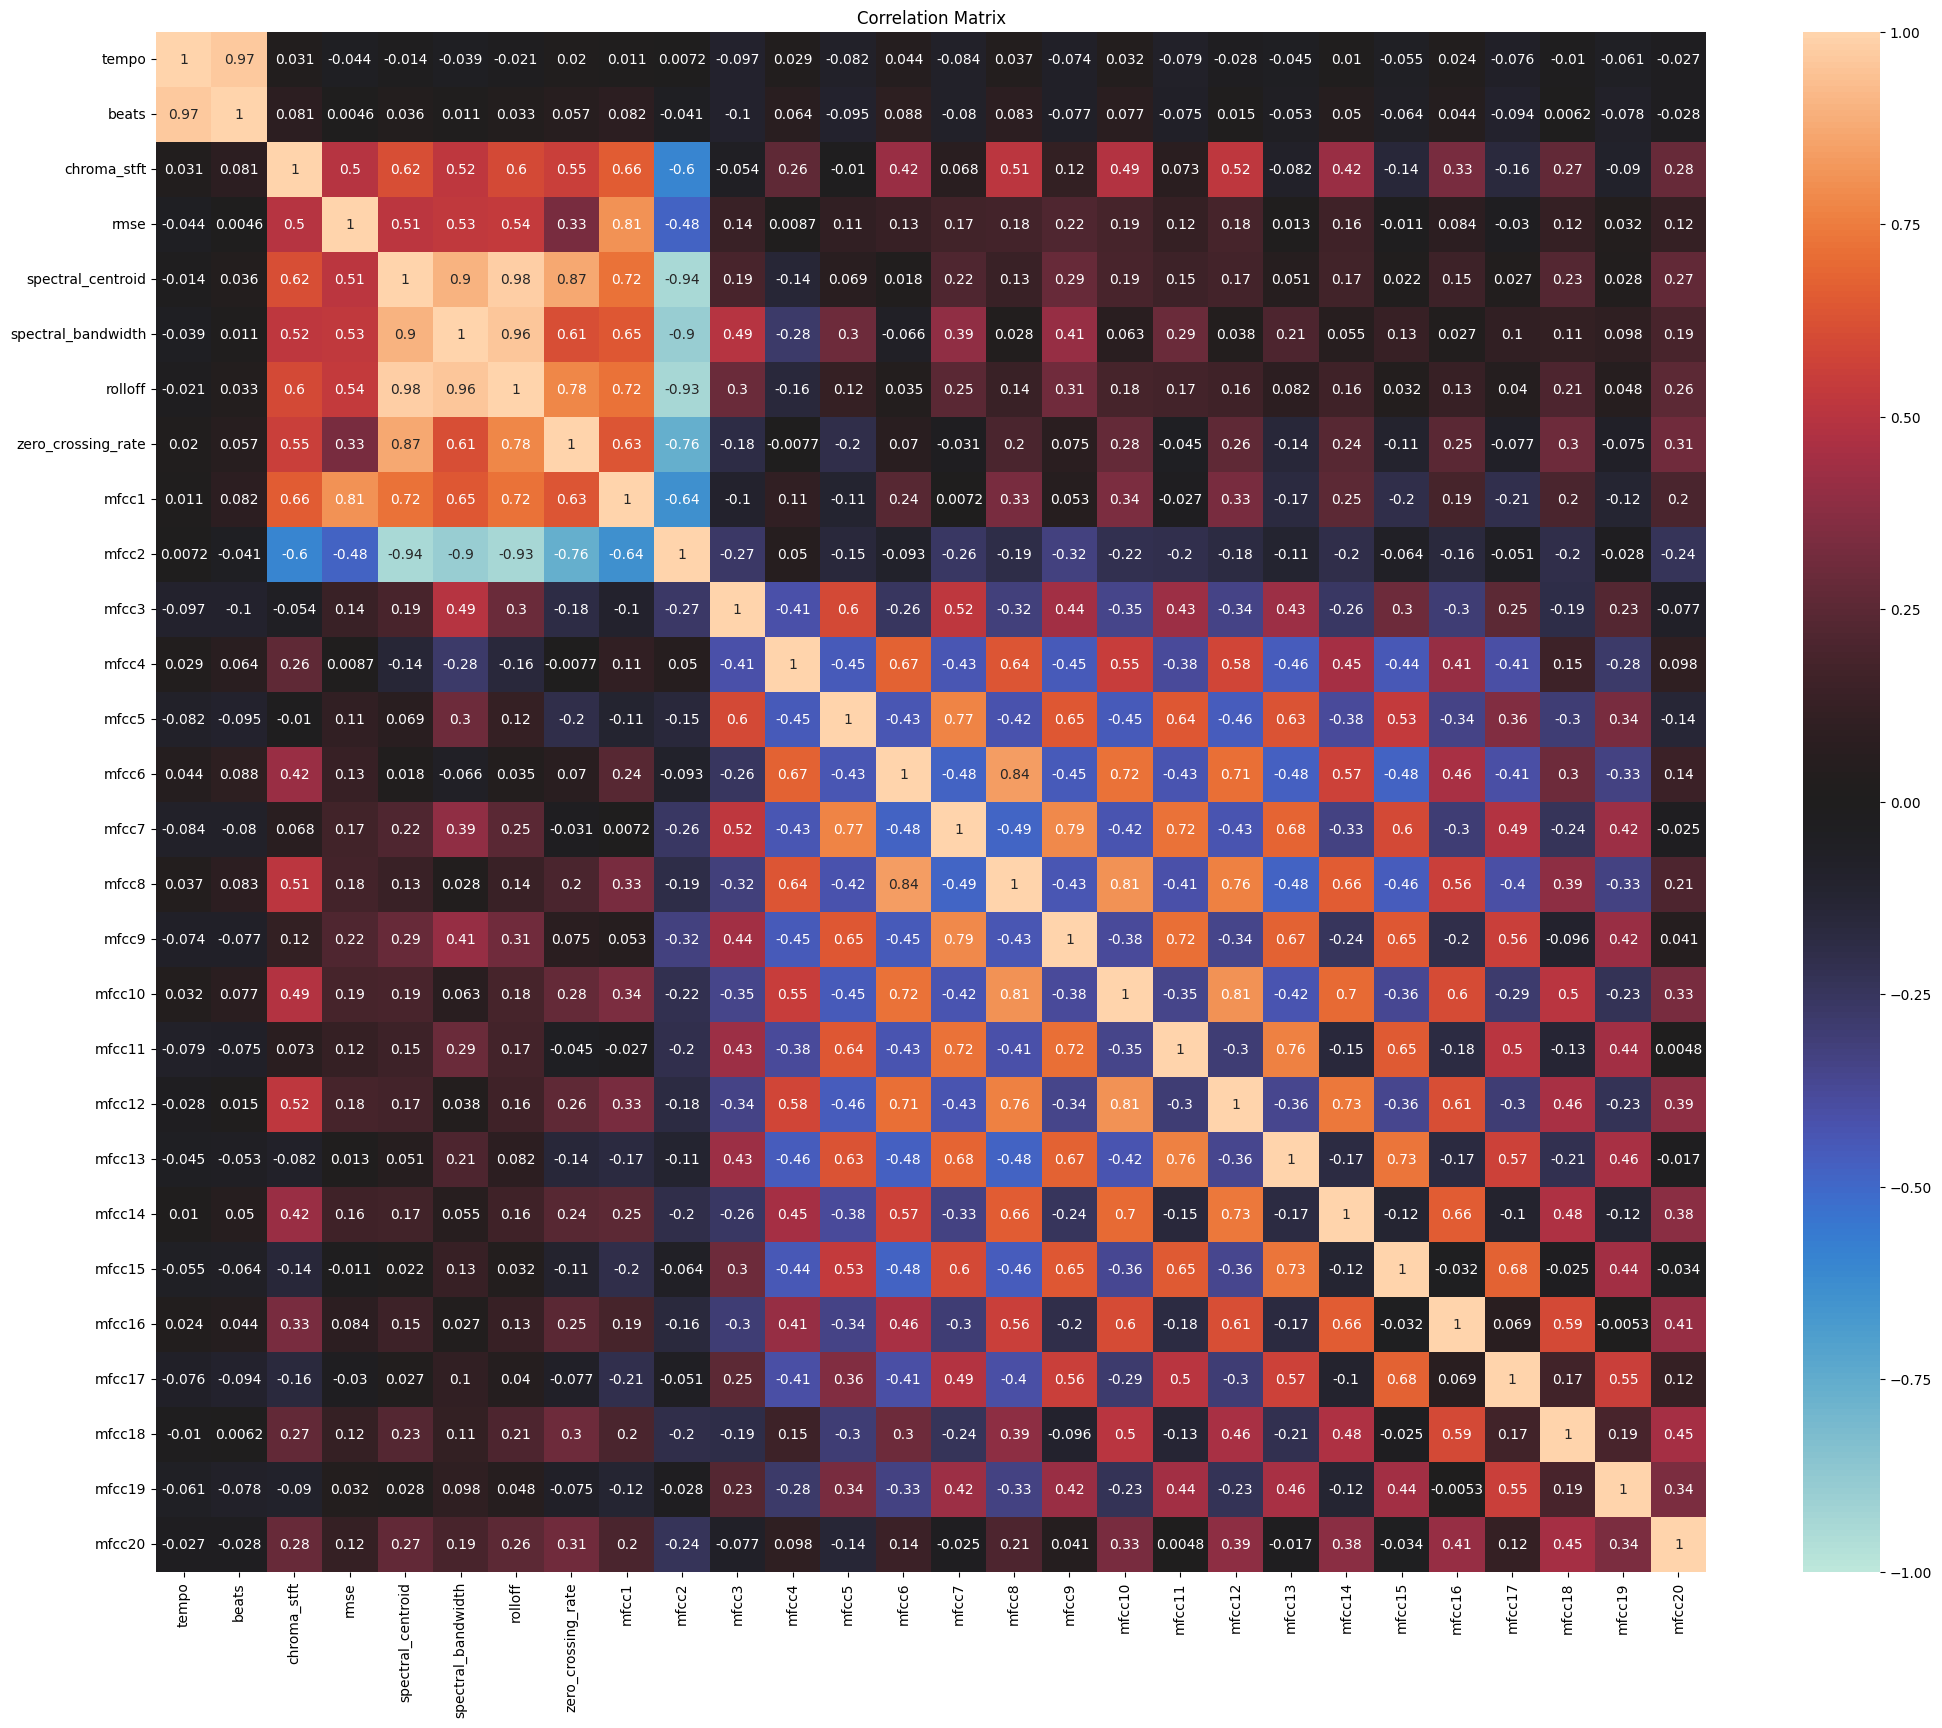

In [398]:
plt.figure(figsize = (25, 20))
sns.heatmap(features.corr(), annot = True, vmin = -1, vmax = 1, center = 0)
plt.title("Correlation Matrix")
plt.show()

The larger the absolute correlation coefficient is, the more important the attribute is.

Building a classifier

In [399]:
targets_ohe = pd.get_dummies(targets)

In [400]:
targets_ohe

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,True,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,False,False,False,False,False,True
996,False,False,False,False,False,False,False,False,False,True
997,False,False,False,False,False,False,False,False,False,True
998,False,False,False,False,False,False,False,False,False,True


Logistic Regression (For Each Target)

In [401]:
# feature engineering: scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
features_name = features.columns

The accuracy for predicting the music type blues is: 0.9166666666666666
Training Accuracy: 0.9242857142857143

Test Accuracy: 0.9166666666666666

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.97      0.96       273
        True       0.56      0.33      0.42        27

    accuracy                           0.92       300
   macro avg       0.75      0.65      0.69       300
weighted avg       0.90      0.92      0.91       300



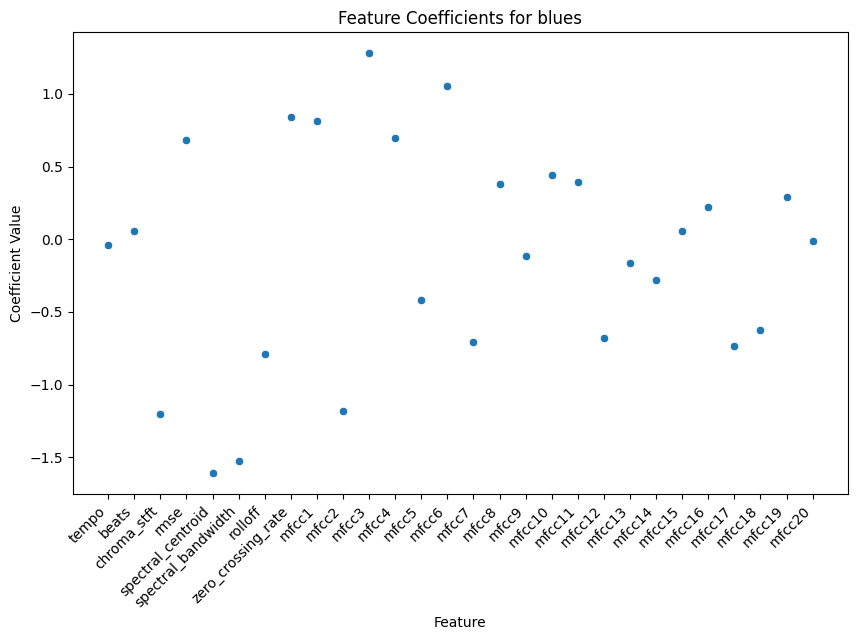

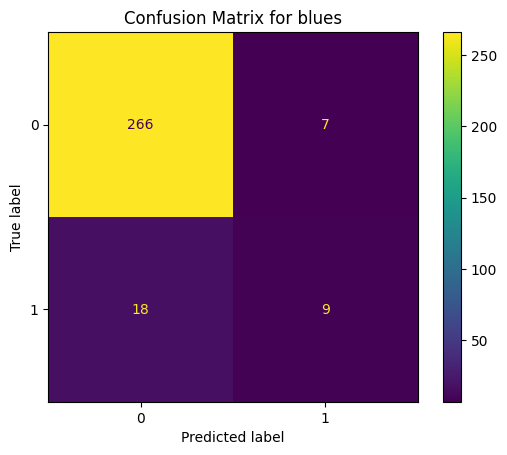

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 clas

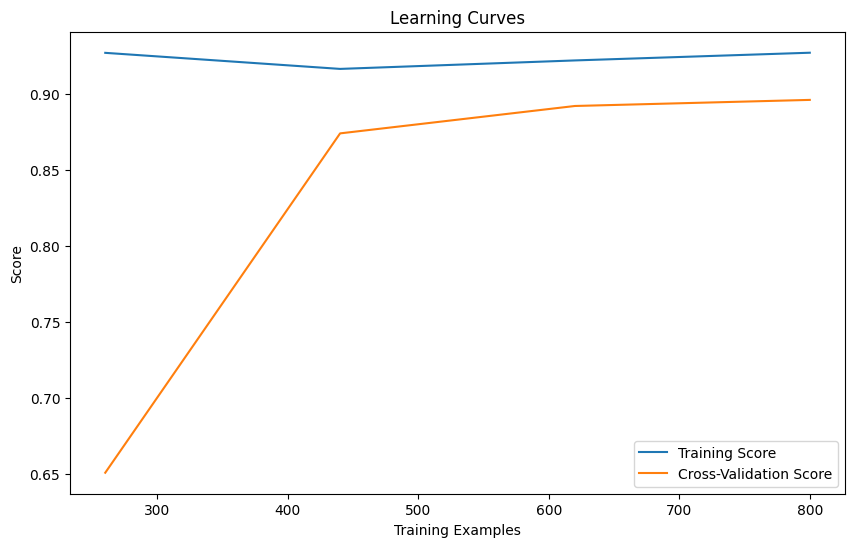

The accuracy for predicting the music type classical is: 0.9733333333333334
Training Accuracy: 0.9871428571428571

Test Accuracy: 0.9733333333333334

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       279
        True       0.81      0.81      0.81        21

    accuracy                           0.97       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.97      0.97      0.97       300



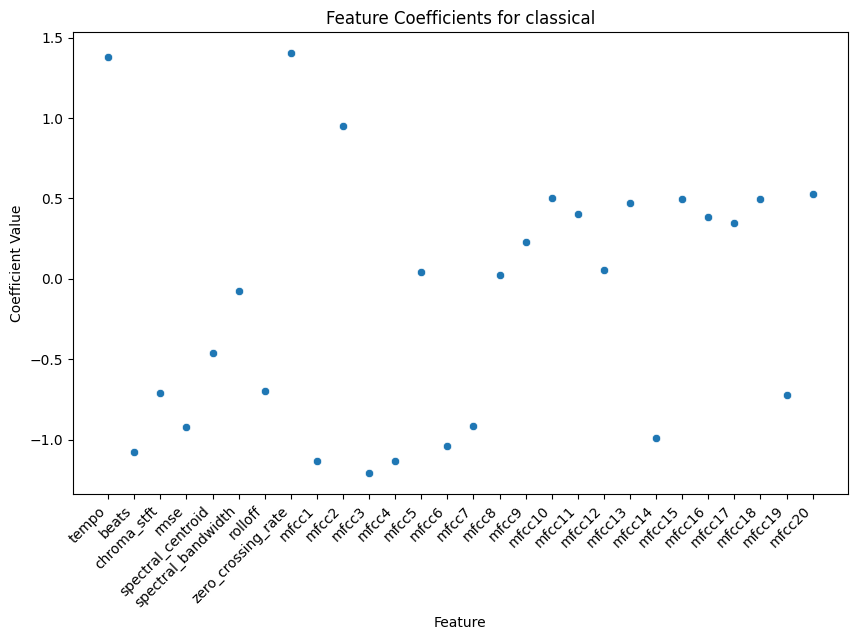

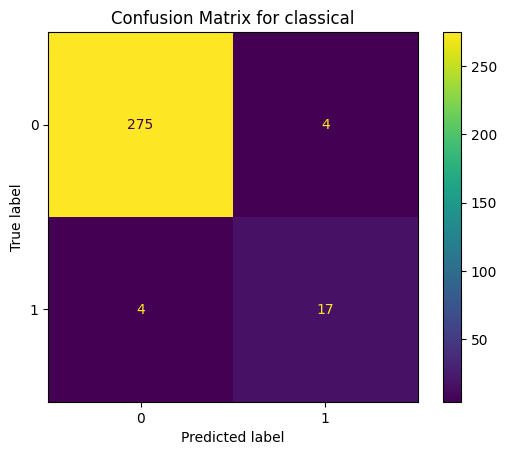

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 clas

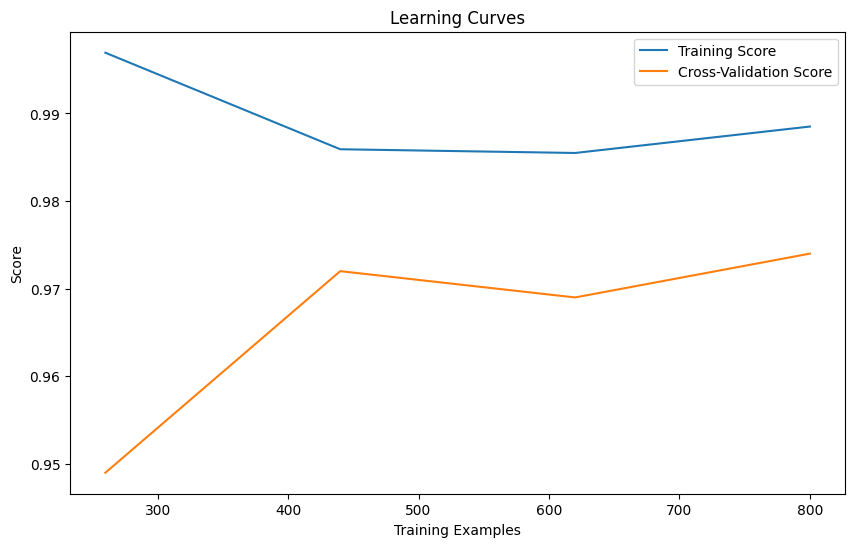

The accuracy for predicting the music type country is: 0.91
Training Accuracy: 0.91

Test Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.99      0.95       267
        True       0.71      0.30      0.43        33

    accuracy                           0.91       300
   macro avg       0.82      0.64      0.69       300
weighted avg       0.90      0.91      0.89       300



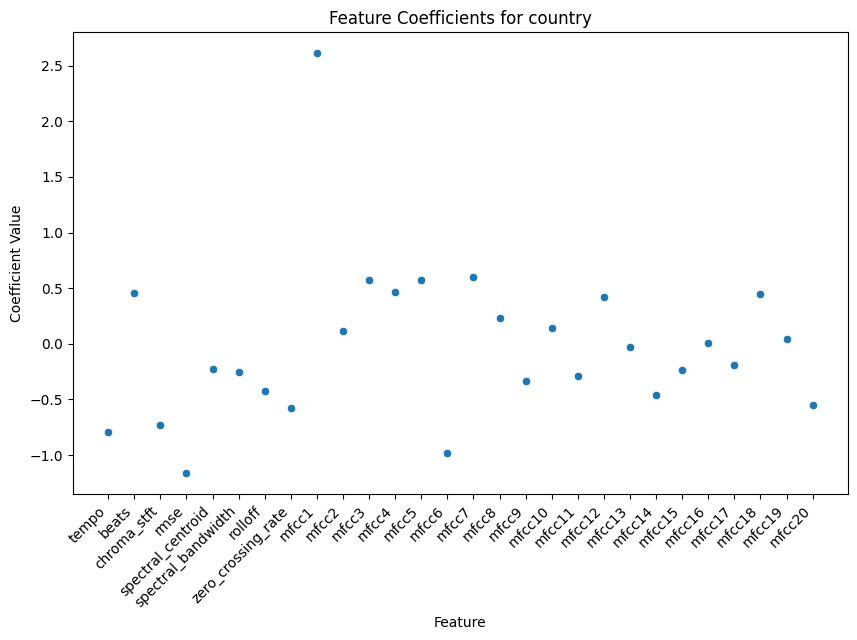

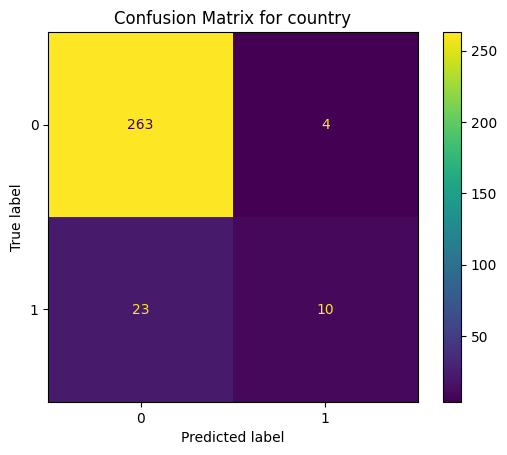

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 clas

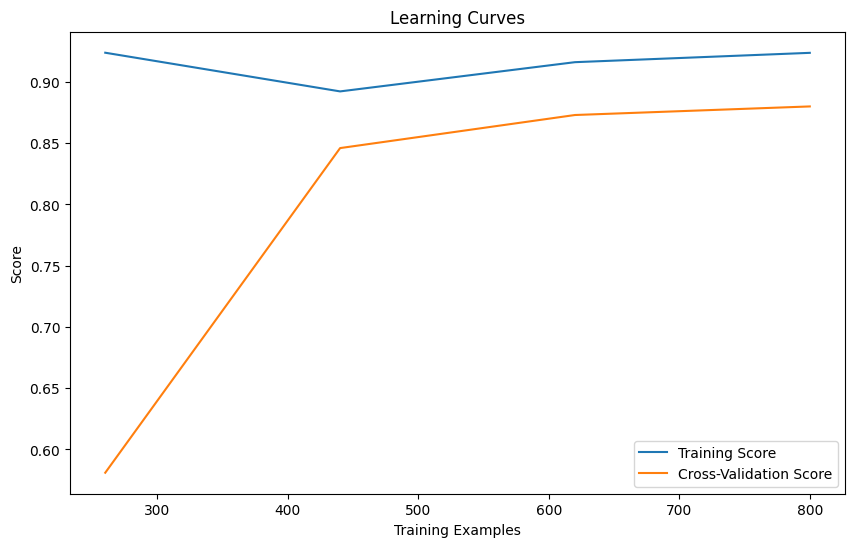

The accuracy for predicting the music type disco is: 0.9133333333333333
Training Accuracy: 0.9171428571428571

Test Accuracy: 0.9133333333333333

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.99      0.95       271
        True       0.67      0.21      0.32        29

    accuracy                           0.91       300
   macro avg       0.79      0.60      0.63       300
weighted avg       0.90      0.91      0.89       300



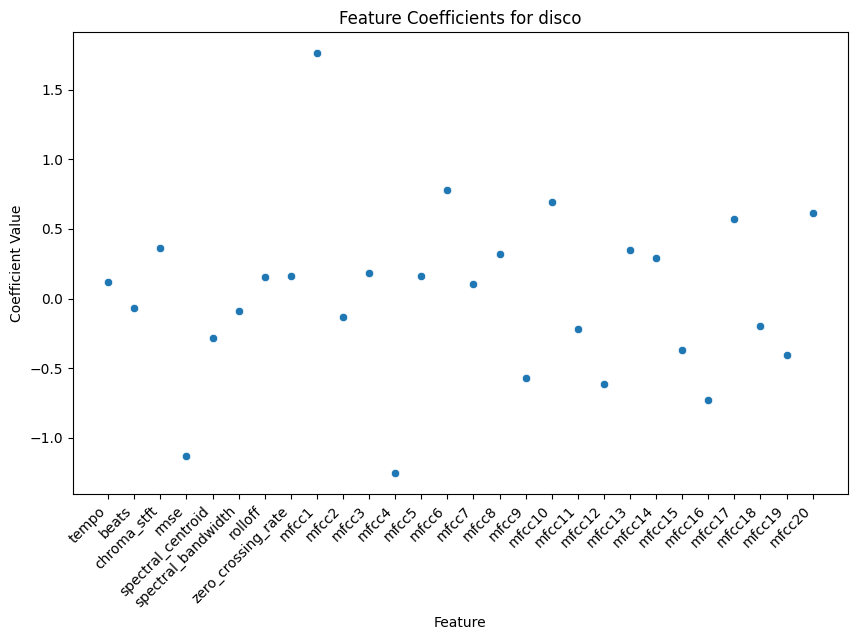

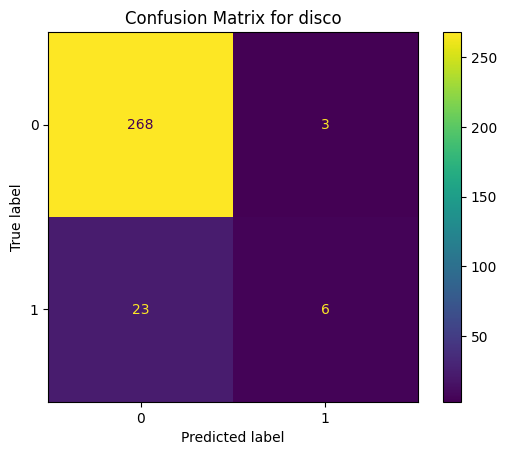

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
8 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 clas

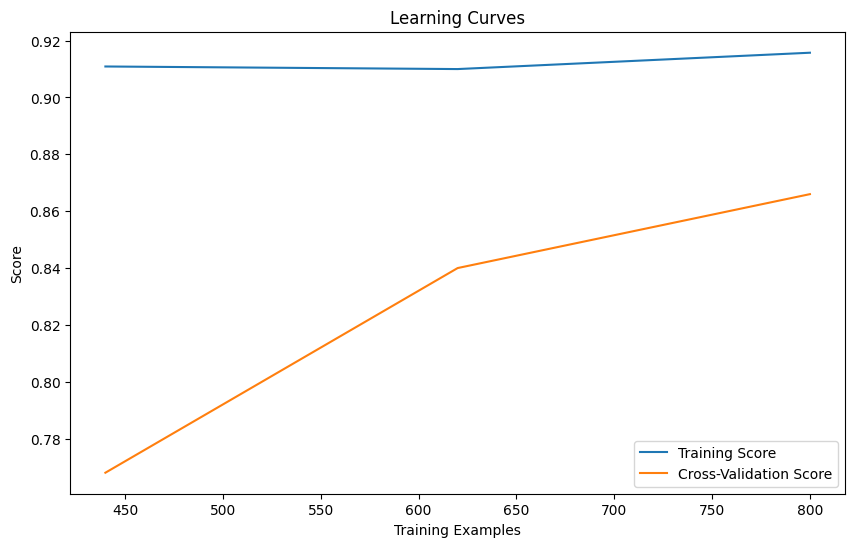

The accuracy for predicting the music type hiphop is: 0.8833333333333333
Training Accuracy: 0.9271428571428572

Test Accuracy: 0.8833333333333333

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.97      0.94       266
        True       0.47      0.24      0.31        34

    accuracy                           0.88       300
   macro avg       0.69      0.60      0.62       300
weighted avg       0.86      0.88      0.87       300



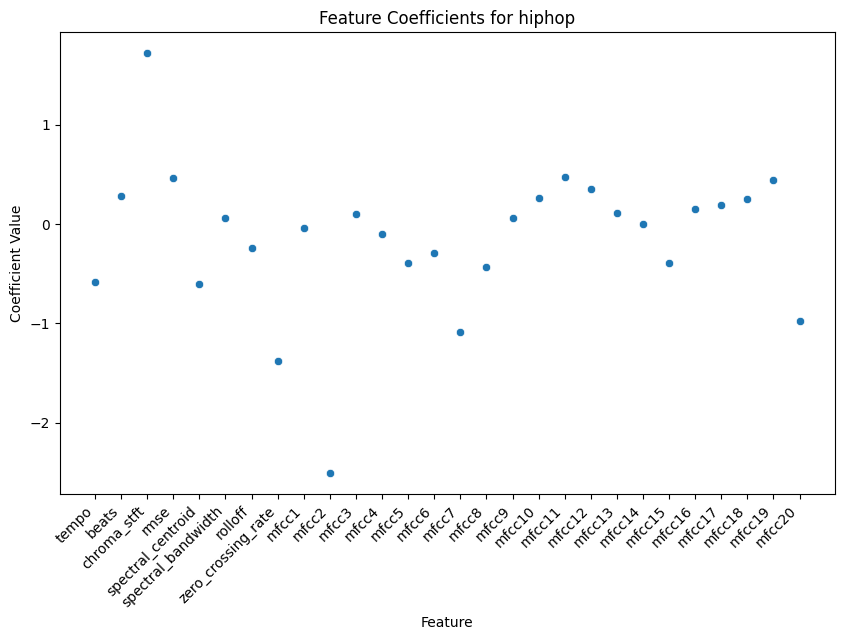

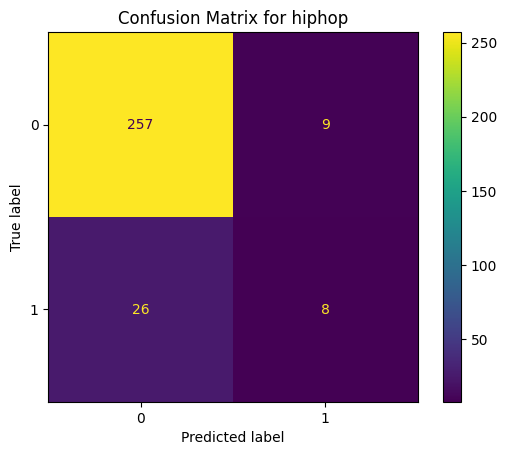

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
8 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 clas

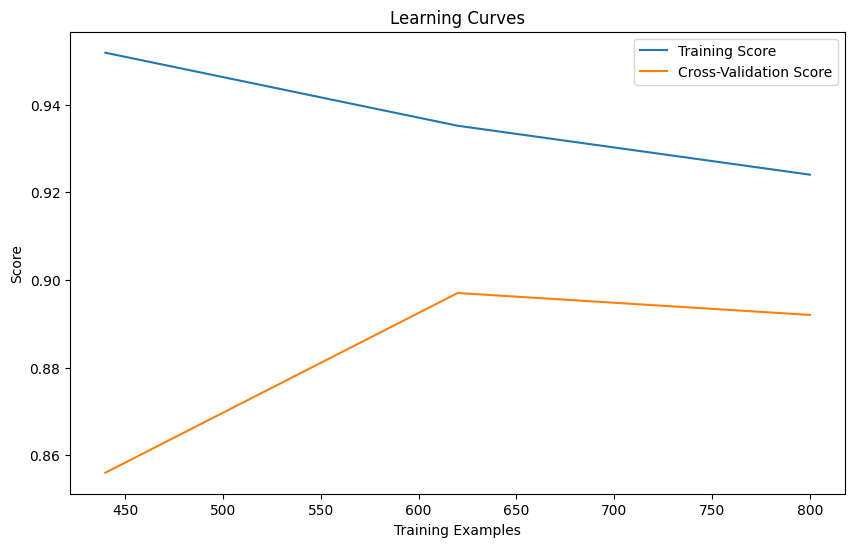

The accuracy for predicting the music type jazz is: 0.9266666666666666
Training Accuracy: 0.93

Test Accuracy: 0.9266666666666666

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.98      0.96       272
        True       0.67      0.43      0.52        28

    accuracy                           0.93       300
   macro avg       0.80      0.70      0.74       300
weighted avg       0.92      0.93      0.92       300



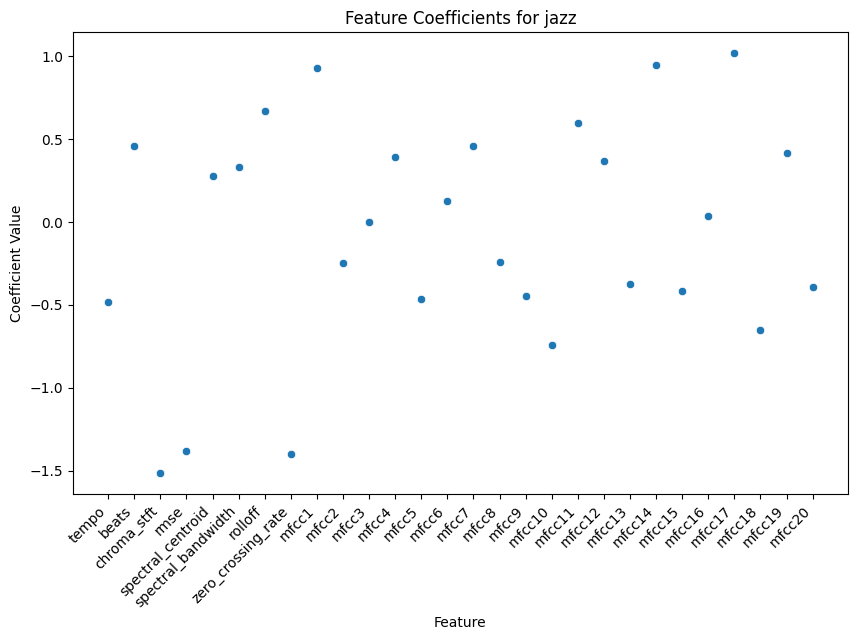

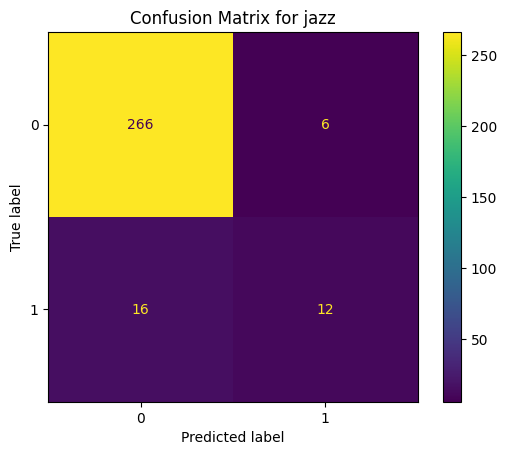

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 cl

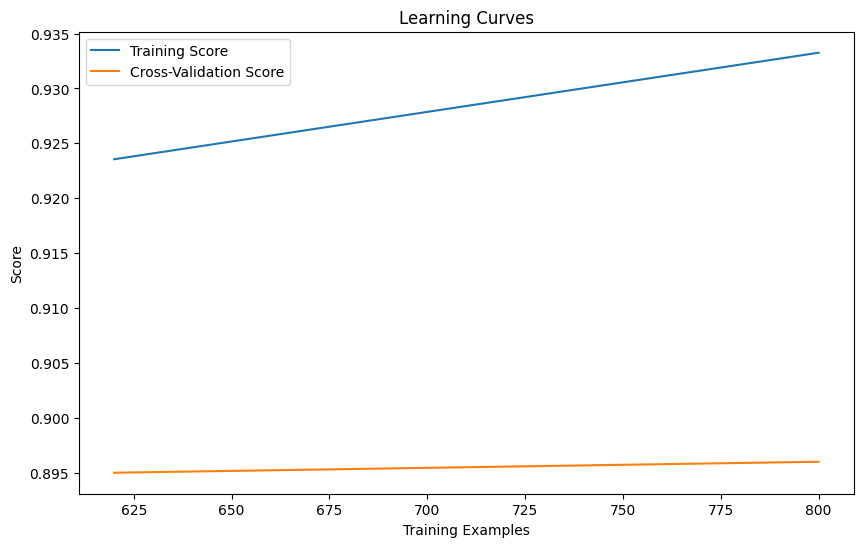

The accuracy for predicting the music type metal is: 0.97
Training Accuracy: 0.9714285714285714

Test Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98       269
        True       0.89      0.81      0.85        31

    accuracy                           0.97       300
   macro avg       0.94      0.90      0.92       300
weighted avg       0.97      0.97      0.97       300



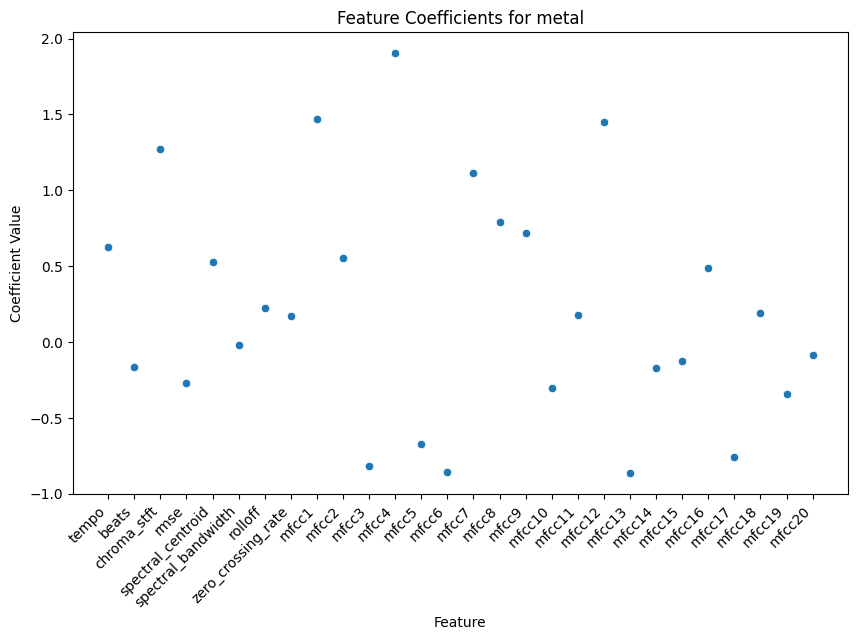

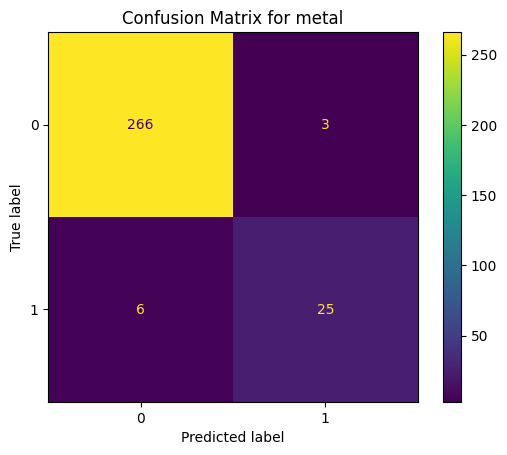

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 cl

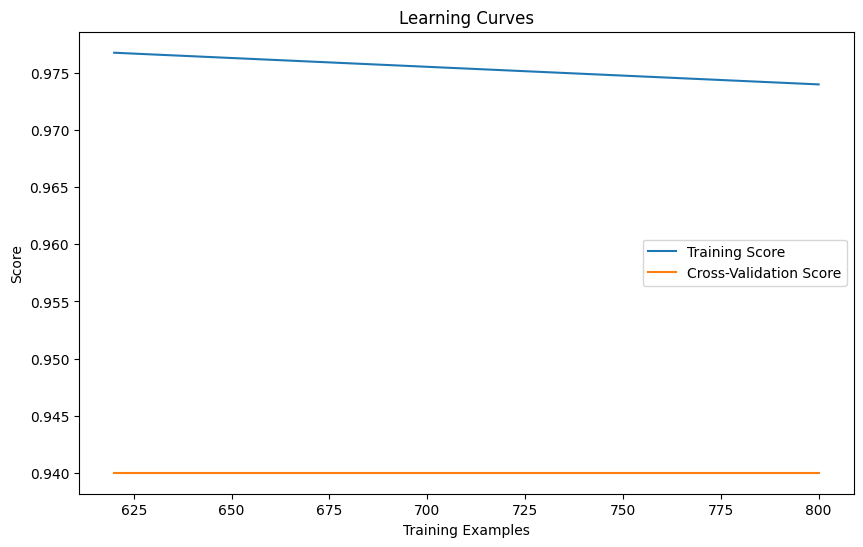

The accuracy for predicting the music type pop is: 0.9566666666666667
Training Accuracy: 0.9757142857142858

Test Accuracy: 0.9566666666666667

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       266
        True       0.84      0.76      0.80        34

    accuracy                           0.96       300
   macro avg       0.90      0.87      0.89       300
weighted avg       0.96      0.96      0.96       300



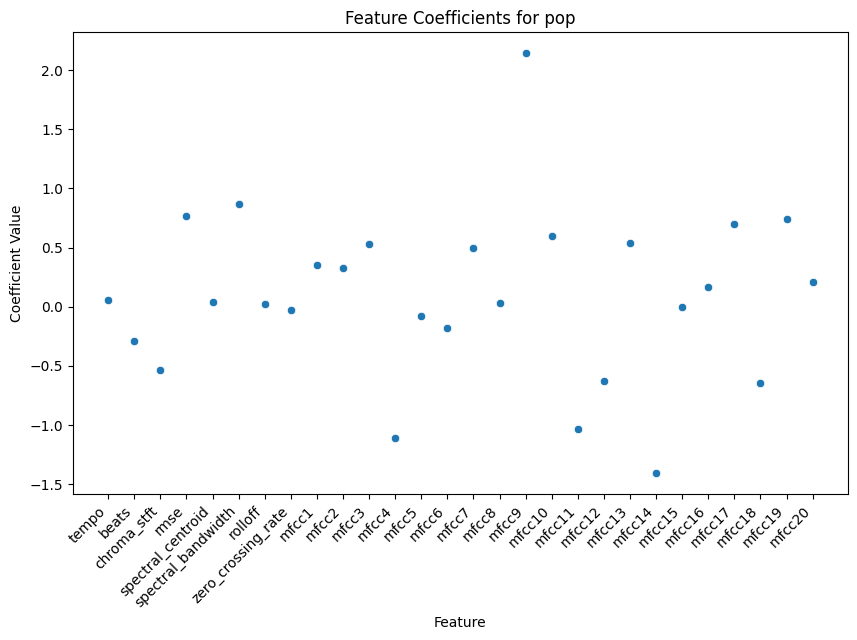

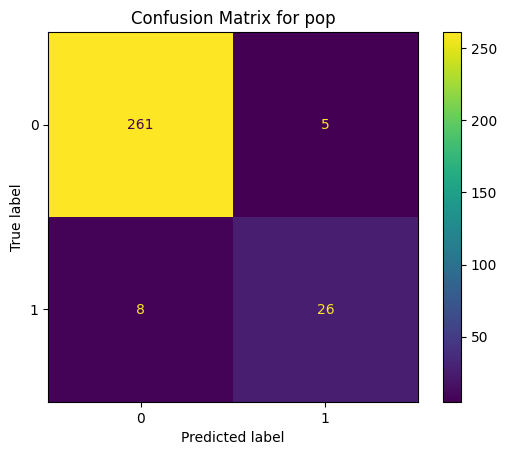

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
16 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 cl

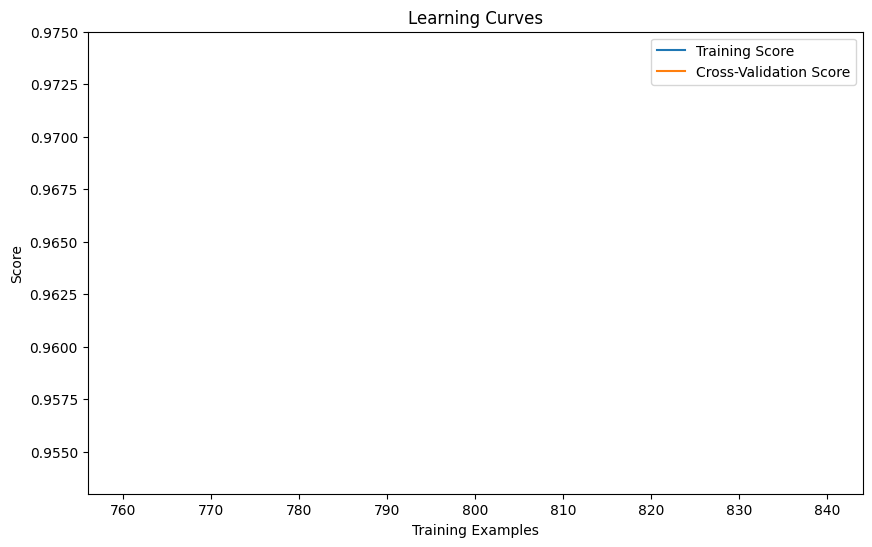

The accuracy for predicting the music type reggae is: 0.92
Training Accuracy: 0.9114285714285715

Test Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.97      0.96       274
        True       0.56      0.35      0.43        26

    accuracy                           0.92       300
   macro avg       0.75      0.66      0.69       300
weighted avg       0.91      0.92      0.91       300



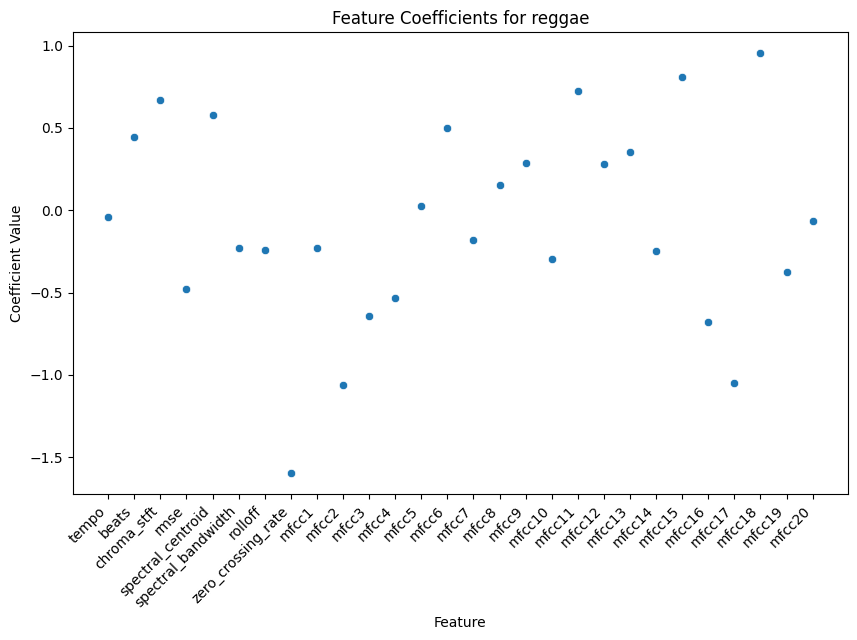

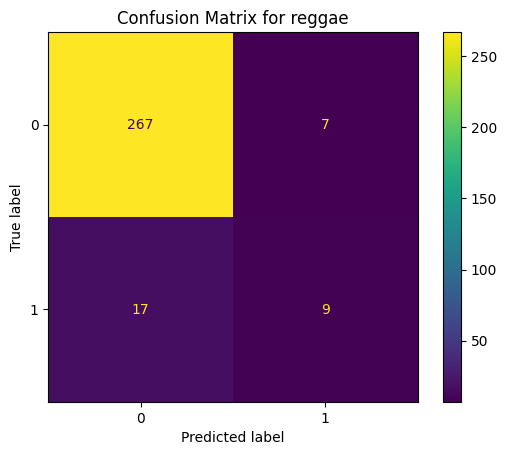

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 cl

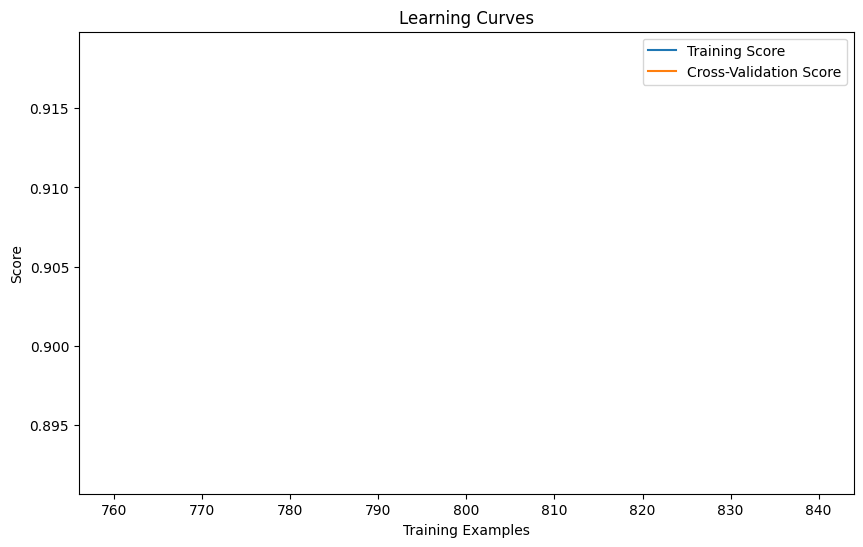

The accuracy for predicting the music type rock is: 0.8766666666666667
Training Accuracy: 0.9128571428571428

Test Accuracy: 0.8766666666666667

Classification Report:
              precision    recall  f1-score   support

       False       0.88      1.00      0.93       263
        True       0.00      0.00      0.00        37

    accuracy                           0.88       300
   macro avg       0.44      0.50      0.47       300
weighted avg       0.77      0.88      0.82       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


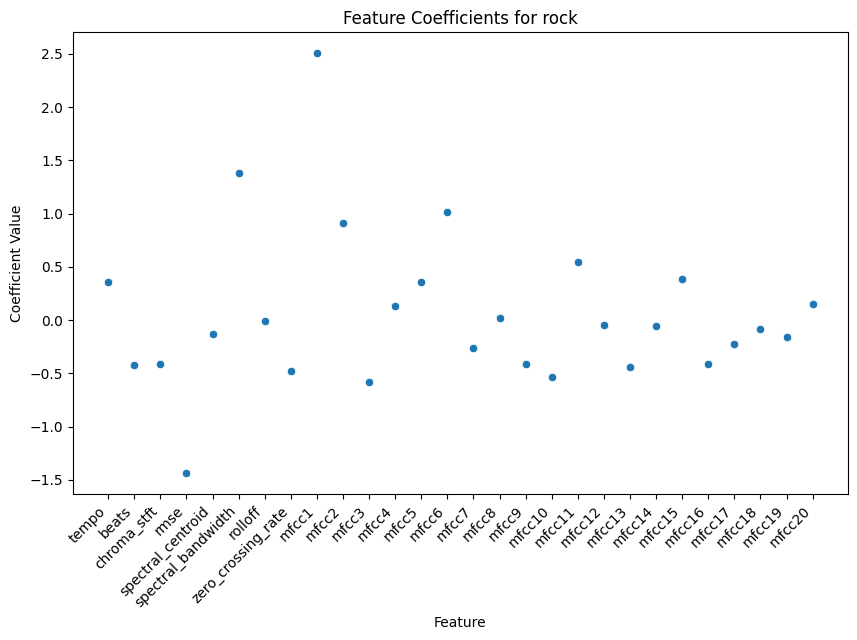

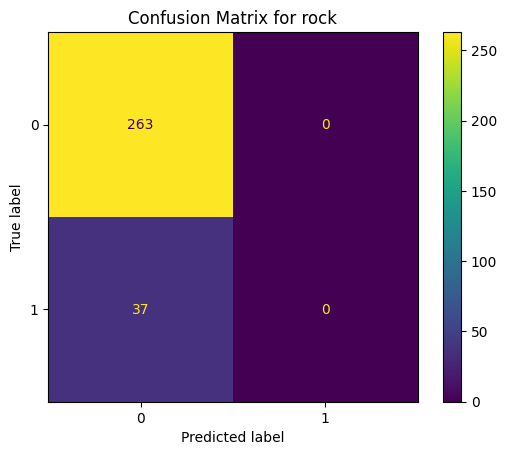

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 cl

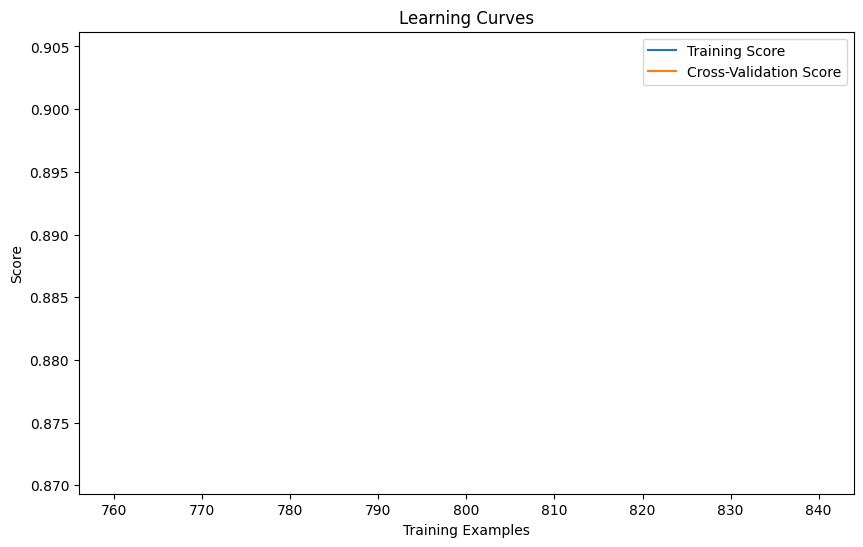

In [402]:
for i in targets_ohe.columns:
  # split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(scaled_features, targets_ohe[i], test_size=0.3, random_state=0)
  logreg = LogisticRegression(max_iter = 1000, solver = 'lbfgs')
  logregmodel = logreg.fit(X_train, y_train)

  yhat_train = logreg.predict(X_train)
  yhat_test = logreg.predict(X_test)
  y_probs = logregmodel.predict_proba(X_test)[:, 1]
  print('The accuracy for predicting the music type '+ i + ' is: ' + str(logreg.score(X_test, y_test)))

  train_accuracy = accuracy_score(y_train, yhat_train)
  print("Training Accuracy:", train_accuracy)

  test_accuracy = accuracy_score(y_test, yhat_test)
  print("\nTest Accuracy:", test_accuracy)

  print("\nClassification Report:")
  print(classification_report(y_test, yhat_test))

  # Model coefficients
  coeff_2D = logregmodel.coef_
  coeff_1D = coeff_2D.flatten()
  coeff_df = pd.DataFrame({'Feature': features_name, 'Coefficient': coeff_1D})
  plt.figure(figsize = (10,6))
  sns.scatterplot(data = coeff_df, x = 'Feature', y = 'Coefficient')
  plt.title("Feature Coefficients for " + i)
  plt.ylabel("Coefficient Value")
  plt.xlabel("Feature")
  plt.xticks(rotation=45, ha='right')
  plt.show()

  ConfusionMatrixDisplay.from_estimator(logregmodel, X_test, y_test, display_labels=[0, 1], cmap='viridis')
  plt.title("Confusion Matrix for " + i)
  plt.show()

  train_sizes, train_scores, test_scores = learning_curve(logreg, scaled_features, targets_ohe[i], cv=5, scoring='accuracy', n_jobs=-1)

  train_scores_mean = np.mean(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)

  plt.figure(figsize=(10, 6))
  plt.plot(train_sizes, train_scores_mean, label='Training Score')
  plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
  plt.xlabel('Training Examples')
  plt.ylabel('Score')
  plt.title('Learning Curves')
  plt.legend()
  plt.show()

Logistic Regression (Multiclass)

In [403]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, targets, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logregmodel = logreg.fit(X_train, y_train)
yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

Training Accuracy: 0.7114285714285714

Test Accuracy: 0.6366666666666667

Classification Report:
              precision    recall  f1-score   support

       blues       0.56      0.74      0.63        27
   classical       0.83      0.90      0.86        21
     country       0.65      0.61      0.62        33
       disco       0.49      0.69      0.57        29
      hiphop       0.56      0.44      0.49        34
        jazz       0.71      0.71      0.71        28
       metal       0.90      0.84      0.87        31
         pop       0.68      0.82      0.75        34
      reggae       0.43      0.46      0.44        26
        rock       0.69      0.30      0.42        37

    accuracy                           0.64       300
   macro avg       0.65      0.65      0.64       300
weighted avg       0.65      0.64      0.63       300



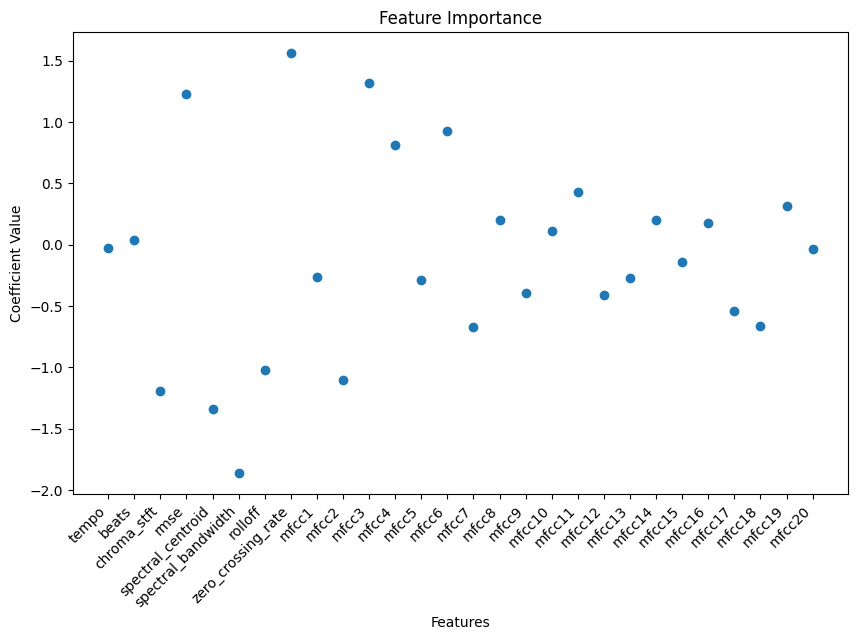

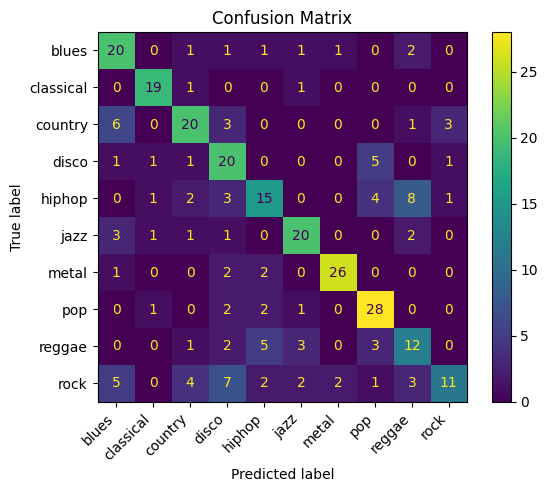

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 clas

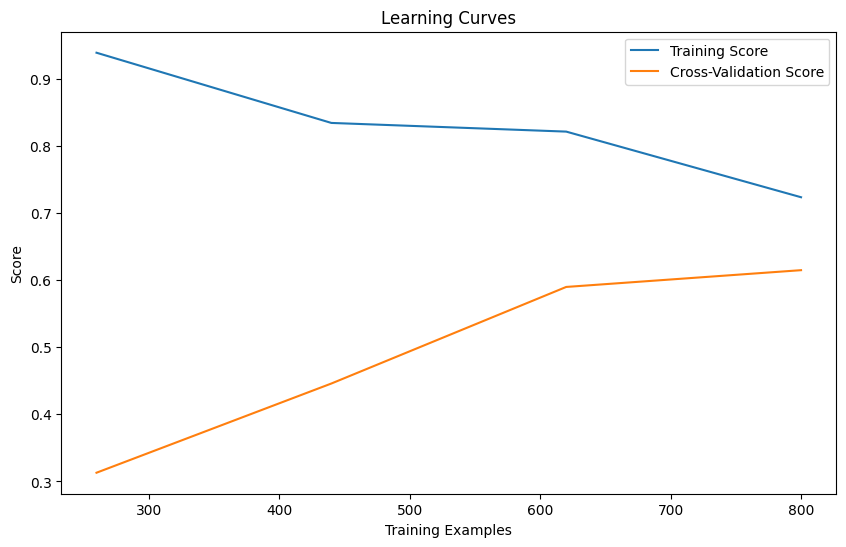

In [404]:
train_accuracy = accuracy_score(y_train, yhat_train)
print("Training Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, yhat_test)
print("\nTest Accuracy:", test_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, yhat_test))

# plots a scatter plot to visualize the importance of each feature as determined by the Logistic Regression Model.
coefficients = logreg.coef_[0]
plt.figure(figsize = (10, 6))
plt.scatter(features_name, coefficients)
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance')
plt.show()

ConfusionMatrixDisplay.from_estimator(logregmodel, X_test, y_test, cmap='viridis')
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

train_sizes, train_scores, test_scores = learning_curve(logreg, scaled_features, targets, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

PCA

In [405]:
# dimensionality reduction with PCA
pca = PCA(n_components = 2)
pca_features = pca.fit_transform(scaled_features)

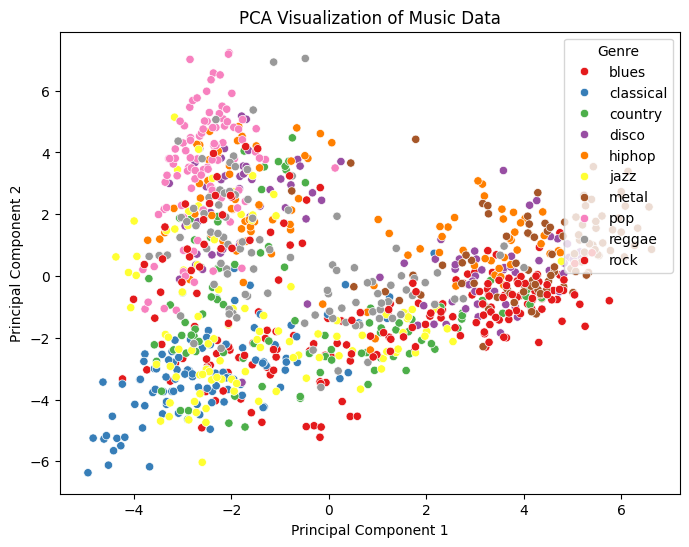

In [406]:
# plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pca_features[:, 0], y = pca_features[:, 1], hue = targets, palette = "Set1")
plt.title("PCA Visualization of Music Data")
plt.xlabel("Principal Component 1") # Principal Component 1: Represents the direction of maximum variance in the data, capturing the most important patterns.
plt.ylabel("Principal Component 2") # Principal Component 2: Orthogonal to PC1, it captures the second most significant variance, highlighting additional data structure.
plt.legend(title = "Genre", loc = 'upper right')
plt.show()

In [407]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, targets, test_size = 0.2, random_state = 42)

In [408]:
# initializes and trains a Random Forest Classifier
# training a Random Forest Classifier to leverage its ability to handle non-linear relationships, identify important features, and provide robust performance for mood classification.
rf = RandomForestClassifier(random_state = 42)
rfmodel = rf.fit(X_train, y_train)

In [409]:
# predictions and evaluation
y_pred = rf.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

       blues       0.65      0.65      0.65        20
   classical       0.81      1.00      0.90        13
     country       0.43      0.48      0.46        27
       disco       0.80      0.38      0.52        21
      hiphop       0.38      0.60      0.46        15
        jazz       0.55      0.50      0.52        22
       metal       0.75      0.84      0.79        25
         pop       0.61      0.85      0.71        13
      reggae       0.53      0.39      0.45        23
        rock       0.24      0.19      0.21        21

    accuracy                           0.56       200
   macro avg       0.57      0.59      0.57       200
weighted avg       0.57      0.56      0.55       200


Accuracy: 0.56


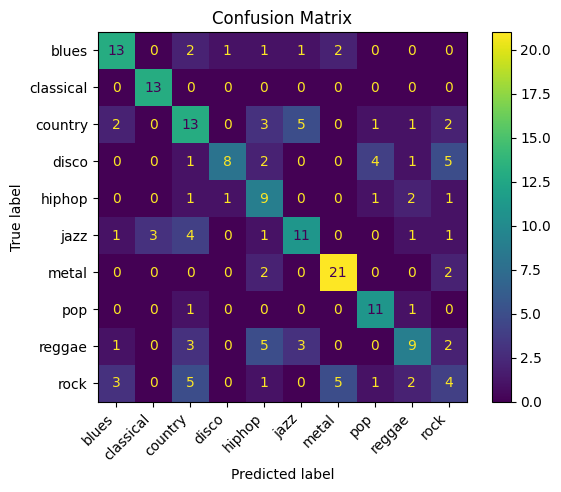

In [410]:
# prints the classification report to provide detailed metrics such as precision, recall, and F1-score for each class, giving a deeper understanding of model performance.
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# calculates and display the overall accuracy of the model, which is the proportion of correctly predicted samples out of the total.
print("\nAccuracy:", accuracy_score(y_test, y_pred))

# displays the confusion matrix to visualize the performance of the classifier by showing the counts of true positive, true negative, false positive, and false negative predictions.
ConfusionMatrixDisplay.from_estimator(rfmodel, X_test, y_test, cmap='viridis')
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

In [411]:
# gets and ranks feature importance scores from the Random Forest model in descending order.
# feature importance visualization
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] # feature importance visualization

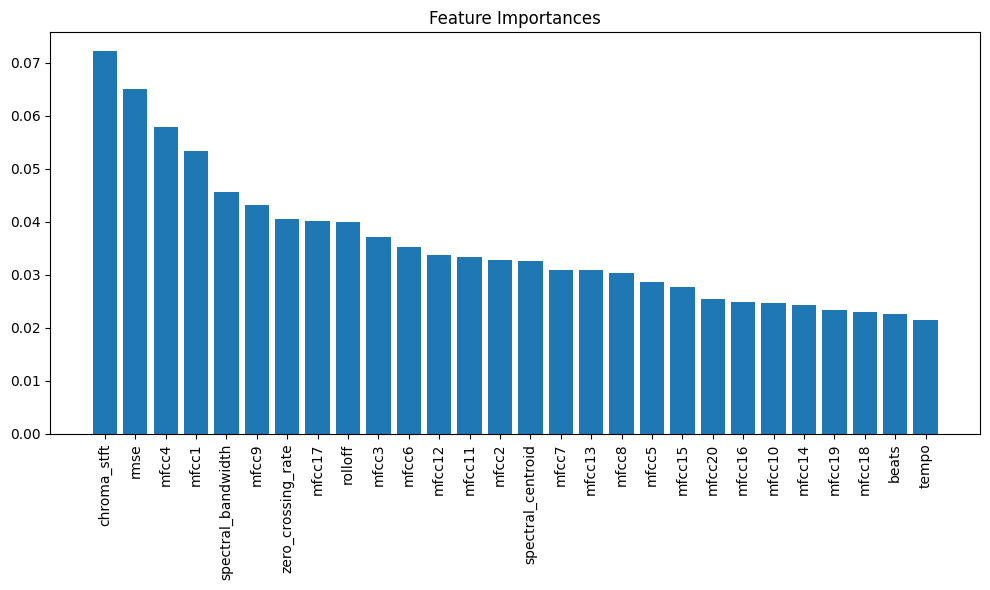

In [412]:
# plots a bar chart to visualize the importance of each feature as determined by the Random Forest model.
plt.figure(figsize = (10, 6))
plt.title("Feature Importances")
plt.bar(range(features.shape[1]), importances[indices], align = "center")
plt.xticks(range(features.shape[1]), features.columns[indices], rotation = 90)
plt.tight_layout()
plt.show()

In [413]:
# performs hyperparameter tuning for the Random Forest model using GridSearchCV to optimize performance.
# hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)
gridmodel = grid_search.fit(X_train, y_train)

In [414]:
print("\nBest Parameters:\n", grid_search.best_params_)
print("\nBest Grid Search Accuracy:", grid_search.best_score_)


Best Parameters:
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Grid Search Accuracy: 0.6524738813325449


In [415]:
# retrains with best parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)


Final Classification Report:
               precision    recall  f1-score   support

       blues       0.68      0.75      0.71        20
   classical       0.76      1.00      0.87        13
     country       0.54      0.56      0.55        27
       disco       0.82      0.43      0.56        21
      hiphop       0.42      0.53      0.47        15
        jazz       0.63      0.55      0.59        22
       metal       0.75      0.84      0.79        25
         pop       0.58      0.85      0.69        13
      reggae       0.50      0.43      0.47        23
        rock       0.35      0.29      0.32        21

    accuracy                           0.60       200
   macro avg       0.60      0.62      0.60       200
weighted avg       0.60      0.60      0.59       200


Final Accuracy: 0.6


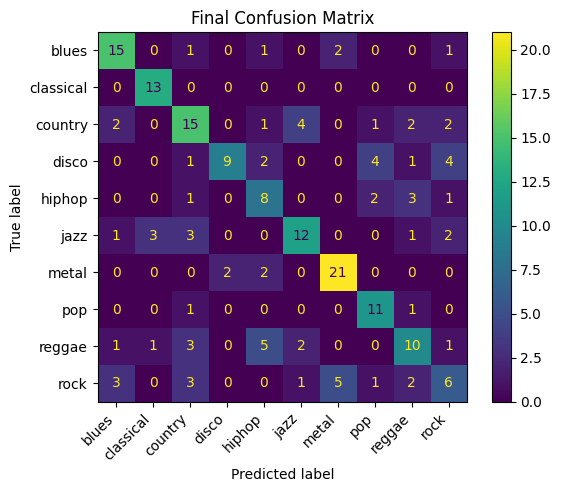

In [416]:
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_best))
print("\nFinal Accuracy:", accuracy_score(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(gridmodel, X_test, y_test, cmap='viridis')
plt.title("Final Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

In [417]:
# feature importance visualization
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1] # feature importance visualization

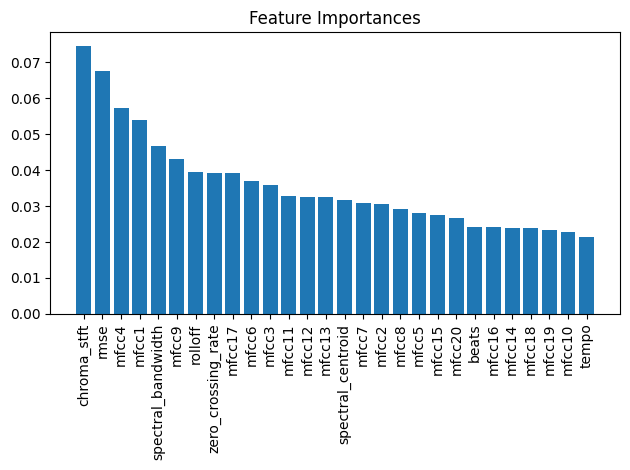

In [418]:
# plots a bar chart to visualize the importance of each feature
plt.title("Feature Importances")
plt.bar(range(features.shape[1]), importances[indices], align = "center")
plt.xticks(range(features.shape[1]), features.columns[indices], rotation = 90)
plt.tight_layout()
plt.show()

In [419]:
# save results, basically shows that what the model predicted as the genre vs the True Label of the genre
output_path = 'classification_results.csv'
pd.DataFrame({'True Label': y_test, 'Predicted Label': y_pred_best}).to_csv(output_path, index = False)
print(f"Classification results saved to {output_path}")

Classification results saved to classification_results.csv


SVM

In [420]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(targets)
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.2, random_state=21)

In [421]:
svm = SVC(kernel ='poly', degree = 2)
svm.fit(X_train,y_train)
y_true = y_test
y_pred = svm.predict(X_test)
target_names = targets_ohe.columns.tolist()
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

       blues       0.50      0.38      0.43        16
   classical       0.90      0.72      0.80        25
     country       0.32      0.44      0.37        18
       disco       0.36      0.31      0.33        26
      hiphop       0.53      0.44      0.48        18
        jazz       0.44      0.25      0.32        16
       metal       0.75      0.79      0.77        19
         pop       0.65      0.68      0.67        19
      reggae       0.63      0.65      0.64        26
        rock       0.23      0.41      0.30        17

    accuracy                           0.52       200
   macro avg       0.53      0.51      0.51       200
weighted avg       0.55      0.52      0.53       200

Accuracy: 0.52


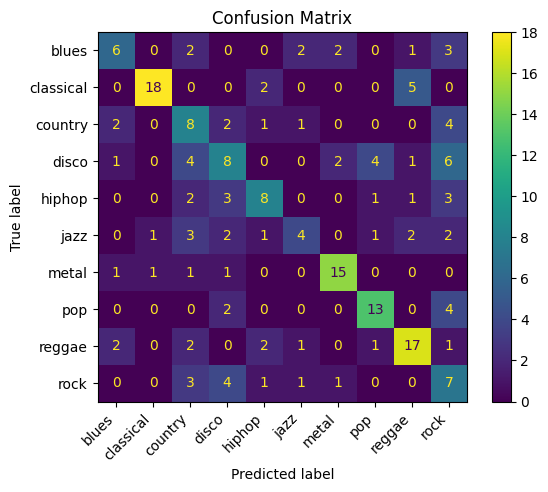

In [422]:
ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test, display_labels=label_encoder.classes_, cmap='viridis')
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

In [423]:
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf', 'poly']}
svm_classifier = SVC()
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy on Test Set: {accuracy}")

Best Hyperparameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy on Test Set: 0.67


In [424]:
smote = SMOTE(random_state=21)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
unique_classes_resampled, class_counts_resampled = np.unique(y_train_resampled, return_counts=True)
for class_label, count in zip(unique_classes_resampled, class_counts_resampled):
    print(f"Frequency of Class {class_label}: {count} instances")

Frequency of Class 0: 84 instances
Frequency of Class 1: 84 instances
Frequency of Class 2: 84 instances
Frequency of Class 3: 84 instances
Frequency of Class 4: 84 instances
Frequency of Class 5: 84 instances
Frequency of Class 6: 84 instances
Frequency of Class 7: 84 instances
Frequency of Class 8: 84 instances
Frequency of Class 9: 84 instances


In [425]:
svm_classifier = SVC(kernel='rbf', C = 10, gamma = 0.1)
svm_classifier.fit(X_train_resampled,y_train_resampled)
y_true = y_test
y_pred = svm_classifier.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

       blues       0.62      0.62      0.62        16
   classical       0.95      0.72      0.82        25
     country       0.67      0.67      0.67        18
       disco       0.52      0.50      0.51        26
      hiphop       0.60      0.50      0.55        18
        jazz       0.60      0.75      0.67        16
       metal       0.94      0.79      0.86        19
         pop       0.62      0.68      0.65        19
      reggae       0.73      0.73      0.73        26
        rock       0.42      0.59      0.49        17

    accuracy                           0.66       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.68      0.66      0.66       200

Accuracy: 0.655


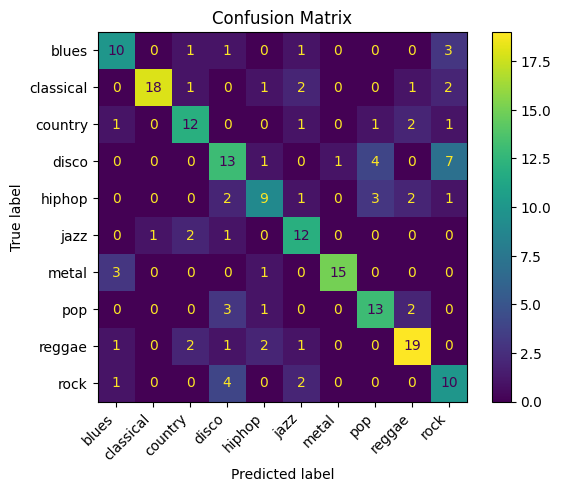

In [426]:
ConfusionMatrixDisplay.from_estimator(svm_classifier, X_test, y_test, display_labels=label_encoder.classes_, cmap='viridis')
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

K-Nearest Neighbor

In [427]:
# feature engineering: scale features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [428]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.2, random_state=21)

k = 10
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_true = y_test
y_pred = knn_classifier.predict(X_test)
print(classification_report(y_true, y_pred, zero_division = 0))
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.54      0.44      0.48        16
           1       0.87      0.80      0.83        25
           2       0.52      0.72      0.60        18
           3       0.48      0.54      0.51        26
           4       0.73      0.44      0.55        18
           5       0.64      0.56      0.60        16
           6       1.00      0.79      0.88        19
           7       0.58      0.79      0.67        19
           8       0.79      0.58      0.67        26
           9       0.36      0.53      0.43        17

    accuracy                           0.62       200
   macro avg       0.65      0.62      0.62       200
weighted avg       0.66      0.62      0.63       200

Accuracy: 0.625


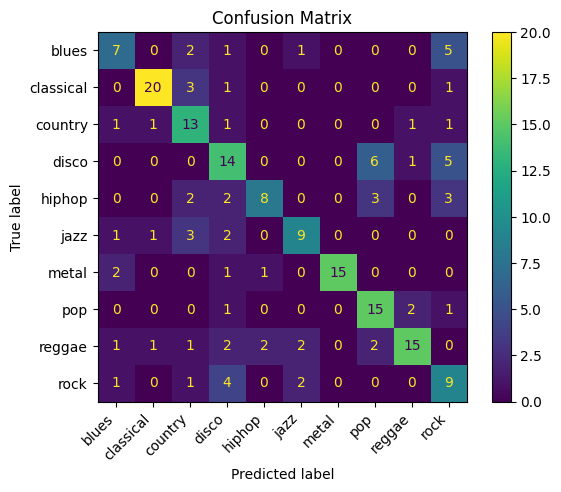

In [429]:
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_test, y_test, display_labels=label_encoder.classes_, cmap='viridis')
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

Spectral Clustering

In [430]:
def similarity(xi, xj, sigma=1.0):
    '''
    calculates RBF similarity between two vectors of the same size

    parameters:
        xi, xj are numpy arrays or other iterable defining two vectors
        sigma is the RBF normalization constant (default 1.0)
    returns:
        the RBF similarity function defined in the cell above for xi, xj
    '''
    return np.exp(-(np.linalg.norm(xi-xj)**2)/(2*sigma**2))

In [431]:
def construct_similarity_matrix(X, sigma=1.0):
    '''
    calculates an affinity matrix using RBF similarity between rows of a matrix

    parameters:
        X is an NxD matrix
        sigma is the RBF normalization constant (default 1.0)
    returns:
        the NxN affinity matrix
    '''

    N = X.shape[0]
    similarity_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            similarity_matrix[i, j] = similarity(X[i], X[j], sigma)
    return similarity_matrix

In [432]:
features_np = features.to_numpy()
distances = sspatial.distance.pdist(features_np, metric='euclidean')
sigma = np.median(distances)
sigma

1794.3066156580537

In [433]:
A = construct_similarity_matrix(features_np, sigma=sigma)

In [434]:
A

array([[1.        , 0.43987415, 0.69473906, ..., 0.71039179, 0.83230054,
        0.96183166],
       [0.43987415, 1.        , 0.88325627, ..., 0.8887763 , 0.79324811,
        0.31885287],
       [0.69473906, 0.88325627, 1.        , ..., 0.99462487, 0.94406977,
        0.56906531],
       ...,
       [0.71039179, 0.8887763 , 0.99462487, ..., 1.        , 0.96231165,
        0.57601568],
       [0.83230054, 0.79324811, 0.94406977, ..., 0.96231165, 1.        ,
        0.69629233],
       [0.96183166, 0.31885287, 0.56906531, ..., 0.57601568, 0.69629233,
        1.        ]])

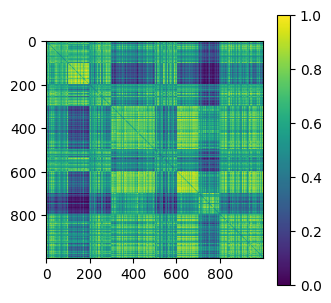

In [435]:
plt.figure(figsize=(3.5,3.5));
plt.imshow(A - np.diag(np.diag(A)));
plt.colorbar();

In [436]:
D = np.diag(A.sum(axis=1))

D_inv_sqrt = np.diag(1.0 / np.sqrt(D.diagonal()))
L = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt

eigenvalues, eigenvectors = np.linalg.eigh(L)
min_eigenvectors = eigenvectors[:, :2]

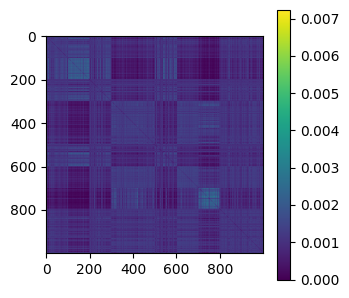

In [437]:
# Visualize Laplacian matrix
plt.figure(figsize=(3.5,3.5))
plt.imshow(-(L - np.diag(np.diag(L))))
plt.colorbar()

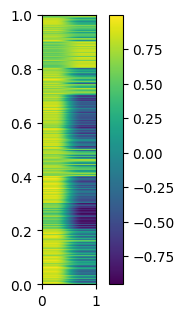

In [438]:
# Normalizing the eigenvectors for K_Means
divmat = np.sqrt(np.sum(min_eigenvectors**2, axis=1)).reshape(-1, 1)
Y = min_eigenvectors / divmat

plt.figure(figsize=(3.5,3.5));
plt.imshow(Y, aspect=5, extent=[0, 1, 0, 1]);
plt.colorbar();

In [439]:
# Run kmeans on eigenvectors and plot spectral clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters).fit(Y)
kk = kmeans.labels_
clusters = []
for i in range(num_clusters):
    clusters.append(np.argwhere(kk == i))

In [440]:
kk

array([4, 3, 3, 3, 7, 4, 1, 7, 3, 3, 3, 3, 1, 3, 3, 6, 1, 7, 3, 7, 8, 0,
       0, 8, 0, 1, 7, 8, 6, 0, 3, 8, 4, 1, 7, 3, 4, 8, 8, 3, 0, 7, 0, 3,
       4, 8, 0, 0, 3, 3, 1, 3, 0, 0, 1, 3, 3, 7, 6, 3, 1, 4, 3, 1, 3, 3,
       0, 6, 1, 3, 3, 2, 3, 3, 8, 3, 3, 8, 0, 7, 3, 6, 0, 4, 0, 3, 1, 6,
       3, 7, 0, 3, 0, 3, 3, 4, 0, 2, 7, 8, 4, 3, 3, 0, 3, 3, 3, 3, 3, 7,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 7, 3, 3, 0, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 7, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 8, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 2, 8, 2, 1, 7, 2, 3, 3, 5, 3, 8, 0, 0, 1, 5, 3, 0, 4, 0, 2,
       0, 5, 4, 9, 8, 4, 7, 3, 2, 1, 0, 7, 0, 2, 7, 3, 0, 0, 0, 7, 7, 1,
       4, 7, 7, 1, 7, 0, 0, 3, 0, 1, 3, 0, 5, 4, 6, 6, 2, 7, 0, 3, 3, 4,
       0, 4, 0, 0, 5, 0, 0, 4, 6, 0, 0, 3, 3, 0, 0, 0, 4, 3, 3, 8, 0, 8,
       0, 3, 0, 3, 3, 7, 7, 4, 7, 0, 7, 3, 5, 0, 2,

In [441]:
for cluster in clusters:
    print(len(cluster))

106
107
84
184
86
78
106
85
96
68


In [442]:
len(targets)

1000

In [443]:
# Label the clusters
count_correct = 0
for cluster in clusters:
    counter = Counter([targets[i] for [i] in cluster])
    most_common, count = counter.most_common(1)[0]
    count_correct += count
    print(most_common)

country
disco
hiphop
classical
reggae
pop
metal
reggae
rock
pop


In [444]:
count_correct/len(targets)

0.305

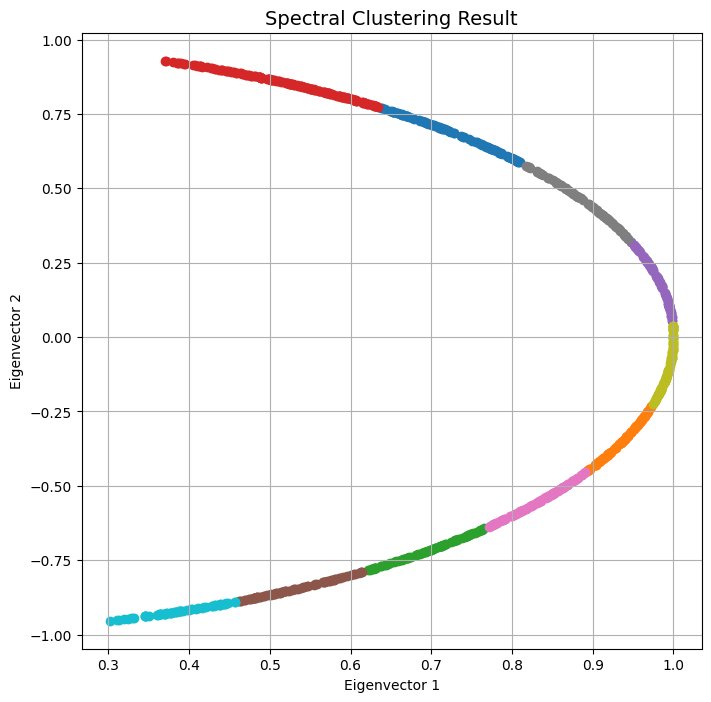

In [445]:
plt.figure(figsize=(8, 8))

# Scatter plot of the spectral embedding
for cluster_label in np.unique(kk):
    cluster_points = Y[kk == cluster_label]  # Get points for the current cluster
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1])

# Add title and labels
plt.title("Spectral Clustering Result", fontsize=14)
plt.xlabel("Eigenvector 1")
plt.ylabel("Eigenvector 2")
plt.grid(True)

# Display the plot
plt.show()

GMM

In [446]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.3, random_state=42)

# Train a GMM for each genre
unique_labels = np.unique(y_train)
gmms = {label: GaussianMixture(n_components=2, random_state=42) for label in unique_labels}

# Fit GMMs
for label in unique_labels:
    gmms[label].fit(X_train[y_train == label])

# Predict using GMMs
def predict_gmm(x):
    likelihoods = [gmms[label].score_samples(x.reshape(1, -1)) for label in unique_labels]
    return unique_labels[np.argmax(likelihoods)]

# Classify test data
y_pred = np.array([predict_gmm(sample) for sample in X_test])

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Output the results
print("\nClassification Report:\n", report)
print("Accuracy:", accuracy)


Classification Report:
               precision    recall  f1-score   support

       blues       0.67      0.23      0.34        35
   classical       0.47      0.90      0.62        20
     country       0.28      0.49      0.35        37
       disco       0.39      0.32      0.35        34
      hiphop       0.21      0.33      0.25        24
        jazz       0.83      0.30      0.44        33
       metal       0.70      0.53      0.60        30
         pop       0.63      0.83      0.72        23
      reggae       0.32      0.34      0.33        29
        rock       0.50      0.31      0.39        35

    accuracy                           0.43       300
   macro avg       0.50      0.46      0.44       300
weighted avg       0.50      0.43      0.43       300

Accuracy: 0.43


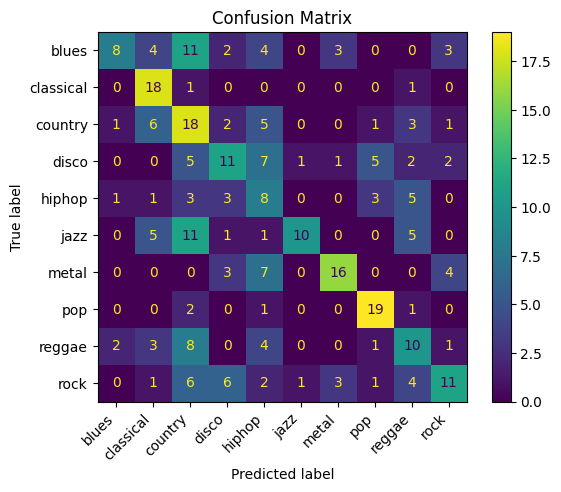

In [447]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

As we can see the accuracy is pretty low, I am going to test the prediction 10 test datas to get an idea of the classifying

In [448]:
for i in range(100):
    # Select a random sample from the test data
    random_index = random.randint(0, X_test.shape[0] - 1)
    random_sample = X_test[random_index]
    true_label = y_test[random_index]

    # Display the sample's true label
    print(f"Prediction {i+1}:")
    print(f"True Label: {label_encoder.inverse_transform([true_label])[0]}")

    # Compute likelihoods for each label
    likelihoods = np.array([gmms[label].score_samples(random_sample.reshape(1, -1)) for label in unique_labels])

    # Predicted label
    predicted_label = unique_labels[np.argmax(likelihoods)]
    predicted_genre = label_encoder.inverse_transform([predicted_label])[0]

    # Display predicted genre
    print(f"Predicted Genre: {predicted_genre}\n")

Prediction 1:
True Label: country
Predicted Genre: country

Prediction 2:
True Label: rock
Predicted Genre: rock

Prediction 3:
True Label: rock
Predicted Genre: country

Prediction 4:
True Label: classical
Predicted Genre: classical

Prediction 5:
True Label: disco
Predicted Genre: pop

Prediction 6:
True Label: country
Predicted Genre: pop

Prediction 7:
True Label: rock
Predicted Genre: rock

Prediction 8:
True Label: hiphop
Predicted Genre: disco

Prediction 9:
True Label: rock
Predicted Genre: hiphop

Prediction 10:
True Label: hiphop
Predicted Genre: reggae

Prediction 11:
True Label: blues
Predicted Genre: country

Prediction 12:
True Label: hiphop
Predicted Genre: pop

Prediction 13:
True Label: classical
Predicted Genre: classical

Prediction 14:
True Label: jazz
Predicted Genre: reggae

Prediction 15:
True Label: rock
Predicted Genre: classical

Prediction 16:
True Label: hiphop
Predicted Genre: reggae

Prediction 17:
True Label: disco
Predicted Genre: disco

Prediction 18:
T

In [449]:
file_path = '/content/drive/MyDrive/hiphop.wav'

new_y, new_sr = librosa.load(file_path, sr=None, duration=30.0)
new_tempo, new_beats = librosa.beat.beat_track(y=new_y, sr=new_sr)
new_beats_count = len(new_beats)
new_tempo = new_tempo[0]

new_chroma_stft = np.mean(np.mean(librosa.feature.chroma_stft(y=new_y, sr=new_sr), axis=1))
new_rmse = np.mean(librosa.feature.rms(y=new_y), axis=1)[0]
new_spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=new_y, sr=new_sr), axis=1)[0]
new_spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=new_y, sr=new_sr), axis=1)[0]
new_rolloff = np.mean(librosa.feature.spectral_rolloff(y=new_y, sr=new_sr), axis=1)[0]
new_zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=new_y), axis=1)[0]

new_mfcc = librosa.feature.mfcc(y=new_y, sr=new_sr, n_mfcc=20)
new_mfcc_means = np.mean(new_mfcc, axis=1)


array1 = [new_tempo, new_beats_count, new_chroma_stft, new_rmse, new_spectral_centroid, new_spectral_bandwidth, new_rolloff, new_zero_crossing_rate]
sample_features =  np.concatenate((array1, new_mfcc_means))

normalized_sample = scaler.transform(sample_features.reshape(1, -1))

predicted_label = predict_gmm(normalized_sample[0])
predicted_class = label_encoder.inverse_transform([predicted_label])[0]

print(predicted_class)

country


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
